<a href="https://colab.research.google.com/github/ethanyoum/Hand-Gesture-Recognition/blob/main/Gesture_Recognition_through_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

In [ ]:
torch.__version__

'2.5.1+cu121'

In [ ]:
import sys
sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

Check if GPU is available and if not change the [runtime](https://www.geeksforgeeks.org/how-to-use-google-colab/).

In [ ]:
# Check if CUDA is available
train_on_gpu  = torch.cuda.is_available()

if not train_on_gpu :
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Downloading the data

The data given on the website [Kaggle Dataset](https://www.kaggle.com/datasets/gti-upm/leapgestrecog/data) is made of one files: `leapGestRecog`. We first need to download and decompress these files.

In [ ]:
# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 64
# Percentage of training set to use as validation
train_size = 0.8
IMG_SIZE = 64

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

print("Path to dataset files:", path)

100%|██████████| 2.13G/2.13G [01:42<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [ ]:
class LeapGestRecogDataset(Dataset):
    def __init__(self, data_path, transform=None, img_size=80):
        self.data_path = data_path
        self.transform = transform
        self.img_size = img_size
        self.x_data = []
        self.y_data = []
        self.lookup = {}
        self.reverselookup = {}
        self.label_count = 0

        # Create label mappings
        for folder_name in os.listdir(os.path.join(data_path, 'leapGestRecog', '00')):
            if not folder_name.startswith('.'):
                self.lookup[folder_name] = self.label_count
                self.reverselookup[self.label_count] = folder_name
                self.label_count += 1

        # Load images and labels
        for i in range(10):
            folder_path = os.path.join(data_path, 'leapGestRecog', f'0{i}')
            for gesture_folder in os.listdir(folder_path):
                if not gesture_folder.startswith('.'):
                    for image_file in os.listdir(os.path.join(folder_path, gesture_folder)):
                        img_path = os.path.join(folder_path, gesture_folder, image_file)
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                        if img is None:
                            print(f"Warning: Image {img_path} could not be loaded.")
                            continue

                        # Resize and add to dataset
                        img = cv2.resize(img, (self.img_size, self.img_size))
                        self.x_data.append(img)
                        self.y_data.append(self.lookup[gesture_folder])

        # Convert list to numpy array and normalize
        self.x_data = np.array(self.x_data, dtype='float32').reshape(-1, self.img_size, self.img_size, 1) / 255.0
        self.y_data = np.array(self.y_data)

        # Shuffle the dataset
        self.x_data, self.y_data = shuffle(self.x_data, self.y_data, random_state=42)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]

        # Convert image to 3 channels to match expected input for some models
        image = np.repeat(image, 3, axis=-1)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
# Define transformations for the data
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Create dataset
full_dataset = LeapGestRecogDataset(data_path=path, transform=data_transforms, img_size=IMG_SIZE)

# Split the dataset into training and validation sets
train_size = int(train_size * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
count = len(test_loader)
inputs_try, labels_try = next(iter(test_loader))

In [ ]:
# Define classes
classes = ['palm','I','fist','fist_moved','thumb','index','ok','palm_moved','c','down']
classes

['palm',
 'I',
 'fist',
 'fist_moved',
 'thumb',
 'index',
 'ok',
 'palm_moved',
 'c',
 'down']

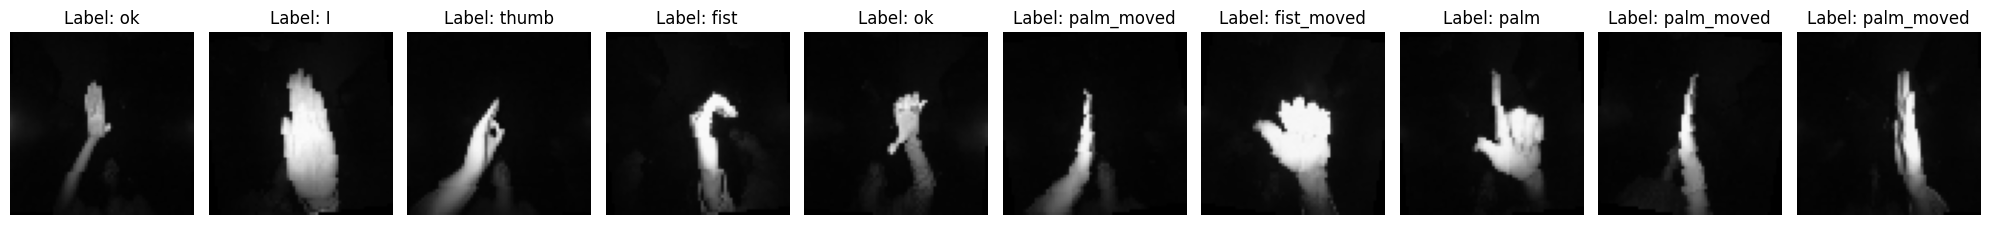

In [ ]:
import matplotlib.pyplot as plt

# Visualize 10 samples from the training dataset
def visualize_training_data(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        # Get a sample image and label
        image, label = dataset[i]

        # Convert the tensor image to a numpy array
        image = image.numpy().transpose((1, 2, 0))

        # Display the original image
        image = image/2 + 0.5

        # Plot the image with label
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {classes[label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_training_data(train_dataset)

## Load VGG Model

In [ ]:
# Define the VGG model
model_vgg = models.vgg16(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [ ]:
outputs_try = model_vgg(inputs_try)

In [ ]:
outputs_try

tensor([[ 0.1072, -0.0793, -0.1032,  ...,  0.0412,  0.0648,  0.0002],
        [-0.0063,  0.0479,  0.0075,  ...,  0.0708, -0.0103, -0.0010],
        [ 0.1171, -0.0321, -0.0683,  ...,  0.0770,  0.0439,  0.0362],
        ...,
        [ 0.0884, -0.0208, -0.0063,  ...,  0.0346,  0.0456, -0.0636],
        [ 0.0886, -0.0368, -0.1744,  ...,  0.0095, -0.0048, -0.0310],
        [ 0.0591,  0.0309, -0.0235,  ...,  0.0862, -0.0277,  0.0551]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
outputs_try.shape

torch.Size([64, 1000])

In [ ]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Number of gesture classes
num_classes = len(full_dataset.lookup)
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
model_vgg = model_vgg.to(device)

In [ ]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
model_vgg = model_vgg.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_vgg = torch.optim.Adam(model_vgg.classifier[6].parameters(),lr = lr)
epochs = 5

In [ ]:
# Define the training function
def train_model(model, dataloader, size, epochs=1,optimizer=None, patience=3):
    all_epoch_loss = []
    all_epoch_acc = []
    model.train()
    #best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs, classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, classes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs.data, 1)

            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)

        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size

        print('Epoch {}/{} - Loss: {:.4f} Acc: {:.4f}'.format(epoch + 1, epochs, epoch_loss, epoch_acc))

        all_epoch_loss.append(epoch_loss)
        all_epoch_acc.append(epoch_acc)

    return model, all_epoch_loss, all_epoch_acc

In [ ]:
# Train the model of VGG16
dset_sizes = {'trainval': len(train_dataset)}
model, training_loss, training_acc = train_model(model_vgg, train_loader, size=dset_sizes['trainval'], epochs=epochs, optimizer=optimizer_vgg)

Epoch 1/5 - Loss: 0.0360 Acc: 0.1112
Epoch 2/5 - Loss: 0.0358 Acc: 0.1331
Epoch 4/5 - Loss: 0.0354 Acc: 0.1436
Epoch 5/5 - Loss: 0.0352 Acc: 0.1608


In [ ]:
# Define training function with Validaiton loss for comparison
def train_model_with_loss_tracking(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Define plot function for loss curves
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the VGG model and plot loss curve
#epochs = 10
#vgg_train_losses, vgg_val_losses = train_model_with_loss_tracking(model_vgg, train_loader, test_loader, criterion, optimizer_vgg, epochs)
#plot_loss_curve(vgg_train_losses, vgg_val_losses)

In [ ]:
def test_model(model, dataloader, size, criterion, num_epochs, device):
    model.eval()
    all_epoch_loss = []
    all_epoch_acc = []

    # Loop over all epochs
    for epoch in range(num_epochs):
        predictions = np.zeros(size)
        all_classes = np.zeros(size)
        all_proba = np.zeros((size, num_classes))

        i = 0
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, classes in dataloader:
                inputs = inputs.to(device)
                classes = classes.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, classes)
                _, preds = torch.max(outputs.data, 1)

                running_loss += loss.item()
                running_corrects += torch.sum(preds == classes.data)

                # Store predictions, true labels, and probabilities
                batch_size = len(classes)
                predictions[i:i+batch_size] = preds.cpu().numpy()
                all_classes[i:i+batch_size] = classes.cpu().numpy()
                all_proba[i:i+batch_size, :] = outputs.cpu().numpy()

                i += batch_size

        # Calculate epoch loss and epoch accuracy
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size

        # Print loss and accuracy for each epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Store epoch loss and accuracy
        all_epoch_loss.append(epoch_loss)
        all_epoch_acc.append(epoch_acc)

    return predictions, all_proba, all_classes, all_epoch_loss, all_epoch_acc

In [ ]:
dset_sizes = {'test': len(test_dataset)}

In [ ]:
import torchvision
from torchvision import transforms

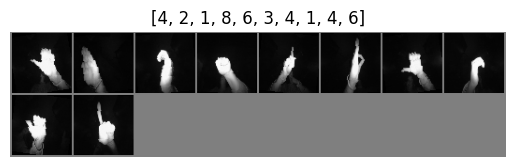

In [ ]:
# Define function to display the image grid
def imshow(tensor, title=None):
    image = tensor.cpu().numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get the `lookup` from the dataset instance
lookup = full_dataset.lookup

# Create the dset_classes list from the lookup dictionary
dset_classes = [class_name for class_name in sorted(lookup.values())]

# Get a batch of validation data
inputs, classes = next(iter(test_loader))

# Set number of images to display
n_images = 10  # You can change this as needed

# Ensure we don't exceed the batch size
inputs_batch = inputs[:n_images]
classes_batch = classes[:n_images]

# Create a grid of images
out = torchvision.utils.make_grid(inputs_batch)

# Display the grid of images with class labels as the title
imshow(out, title=[dset_classes[x] for x in classes_batch])  # Mapping numeric labels to class names

# ResNet Model

In [ ]:
from torchvision.models import ResNet18_Weights

# Define ResNet model
model_resnet = models.resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
num_classes = 10


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [ ]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_resnet = model_resnet.to(device)

outputs_try = model_resnet(inputs_try)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr = 0.001)

resnet_train_losses, resnet_val_losses = train_model_with_loss_tracking(model_resnet, train_loader = train_loader,
                                                                        val_loader = test_loader,
                                                                        criterion = criterion, optimizer = optimizer_resnet,
                                                                        epochs = epochs)

Epoch 1/10 - Train Loss: 0.2951, Val Loss: 0.2804
Epoch 2/10 - Train Loss: 0.0346, Val Loss: 0.0333
Epoch 3/10 - Train Loss: 0.0391, Val Loss: 0.0597
Epoch 4/10 - Train Loss: 0.0182, Val Loss: 0.0030
Epoch 5/10 - Train Loss: 0.0316, Val Loss: 0.0317
Epoch 6/10 - Train Loss: 0.0224, Val Loss: 0.6481
Epoch 7/10 - Train Loss: 0.0239, Val Loss: 0.0040
Epoch 8/10 - Train Loss: 0.0194, Val Loss: 0.0356
Epoch 9/10 - Train Loss: 0.0117, Val Loss: 0.0038
Epoch 10/10 - Train Loss: 0.0163, Val Loss: 0.0189


# Build CNN Model

In [ ]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(2, 2))
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv3_bn = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool3(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# create a complete CNN
model_CNN = ImprovedNet()
model_CNN

ImprovedNet(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If using GPU, move the model to GPU
if torch.cuda.is_available():
    model_CNN = model_CNN.cuda()
else:
    model_CNN = model_CNN.to(device)

In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0001)

In [ ]:
dset_sizes = {'trainval': len(train_dataset)}
model_cnn, training_loss, training_acc = train_model(model_CNN, train_loader, size=dset_sizes['trainval'], epochs=epochs, optimizer=optimizer)

Epoch 1/10 - Loss: 0.0179 Acc: 0.6497
Epoch 2/10 - Loss: 0.0053 Acc: 0.9114
Epoch 3/10 - Loss: 0.0026 Acc: 0.9597
Epoch 4/10 - Loss: 0.0016 Acc: 0.9788
Epoch 5/10 - Loss: 0.0010 Acc: 0.9886
Epoch 6/10 - Loss: 0.0008 Acc: 0.9894
Epoch 7/10 - Loss: 0.0006 Acc: 0.9932
Epoch 8/10 - Loss: 0.0004 Acc: 0.9954
Epoch 9/10 - Loss: 0.0004 Acc: 0.9946
Epoch 10/10 - Loss: 0.0003 Acc: 0.9964


In [ ]:
dset_sizes = {'test': len(test_dataset)}
num_classes = len(full_dataset.lookup)
predictions_CNN, all_proba_CNN, all_classes_CNN, test_loss_CNN, test_acc_CNN = test_model(model_CNN,
test_loader, size=dset_sizes['test'], criterion=criterion, num_epochs = epochs,device=device)

Epoch 1/10 - Loss: 0.0001 Acc: 0.9992
Epoch 2/10 - Loss: 0.0001 Acc: 0.9995
Epoch 3/10 - Loss: 0.0001 Acc: 0.9998
Epoch 4/10 - Loss: 0.0001 Acc: 0.9995
Epoch 5/10 - Loss: 0.0001 Acc: 0.9992
Epoch 6/10 - Loss: 0.0001 Acc: 0.9990
Epoch 7/10 - Loss: 0.0001 Acc: 0.9995
Epoch 8/10 - Loss: 0.0001 Acc: 0.9990
Epoch 9/10 - Loss: 0.0001 Acc: 0.9995
Epoch 10/10 - Loss: 0.0001 Acc: 0.9998


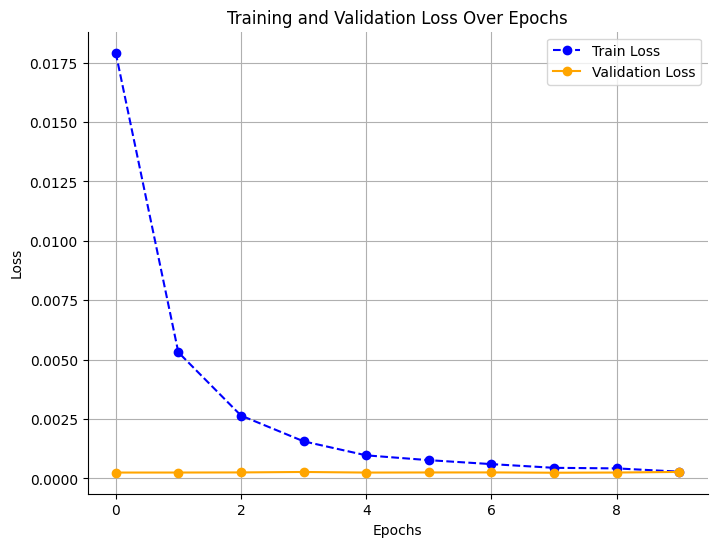

In [ ]:
def plot_loss_curve(train_losses, val_losses):
   plt.figure(figsize=(8, 6))  # Adjust figure size

    # Plot Training Loss (Blue, Dashed Line, Markers)
   plt.plot(range(len(train_losses)), train_losses, 'bo--', label='Train Loss')

    # Plot Validation Loss (Orange, Solid Line, Circle Markers)
   plt.plot(range(len(val_losses)), val_losses, 'o-', color='orange', label='Validation Loss')

   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.title('Training and Validation Loss Over Epochs')

   plt.legend(loc='upper right')  # Position legend in upper right
   plt.grid(True)

    # Add a border effect similar to the image
   plt.gca().spines['top'].set_visible(False)
   plt.gca().spines['right'].set_visible(False)

    # Show the plot
   plt.show()

plot_loss_curve(train_losses = training_loss, val_losses = test_loss_CNN)

In [ ]:
class ImprovedNetAgain(nn.Module):
    def __init__(self):
        super(ImprovedNetAgain, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(2, 2))
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.conv3_bn = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool3(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = ImprovedNetAgain().to(device)
optimizer_again = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dset_sizes = {'trainval': len(train_dataset)}
model_cnn_2, training_loss_2, training_acc_2 = train_model(model, train_loader, size=dset_sizes['trainval'], epochs=epochs, optimizer=optimizer_again)

Epoch 1/10 - Loss: 0.0242 Acc: 0.5002
Epoch 2/10 - Loss: 0.0103 Acc: 0.8153
Epoch 3/10 - Loss: 0.0060 Acc: 0.8952
Epoch 4/10 - Loss: 0.0041 Acc: 0.9338
Epoch 5/10 - Loss: 0.0030 Acc: 0.9523
Epoch 6/10 - Loss: 0.0022 Acc: 0.9654
Epoch 7/10 - Loss: 0.0017 Acc: 0.9735
Epoch 8/10 - Loss: 0.0014 Acc: 0.9775
Epoch 9/10 - Loss: 0.0011 Acc: 0.9839
Epoch 10/10 - Loss: 0.0010 Acc: 0.9854


In [ ]:
dset_sizes = {'test': len(test_dataset)}
num_classes = len(full_dataset.lookup)
predictions_CNN, all_proba_CNN, all_classes_CNN, test_loss_CNN, test_acc_CNN = test_model(model,
test_loader, size=dset_sizes['test'], criterion=criterion, num_epochs = epochs,device=device)

Epoch 1/10 - Loss: 0.0002 Acc: 0.9975
Epoch 2/10 - Loss: 0.0002 Acc: 0.9965
Epoch 3/10 - Loss: 0.0003 Acc: 0.9962
Epoch 4/10 - Loss: 0.0003 Acc: 0.9975
Epoch 5/10 - Loss: 0.0002 Acc: 0.9975
Epoch 6/10 - Loss: 0.0003 Acc: 0.9968
Epoch 7/10 - Loss: 0.0003 Acc: 0.9968
Epoch 8/10 - Loss: 0.0002 Acc: 0.9970
Epoch 9/10 - Loss: 0.0002 Acc: 0.9972
Epoch 10/10 - Loss: 0.0003 Acc: 0.9970


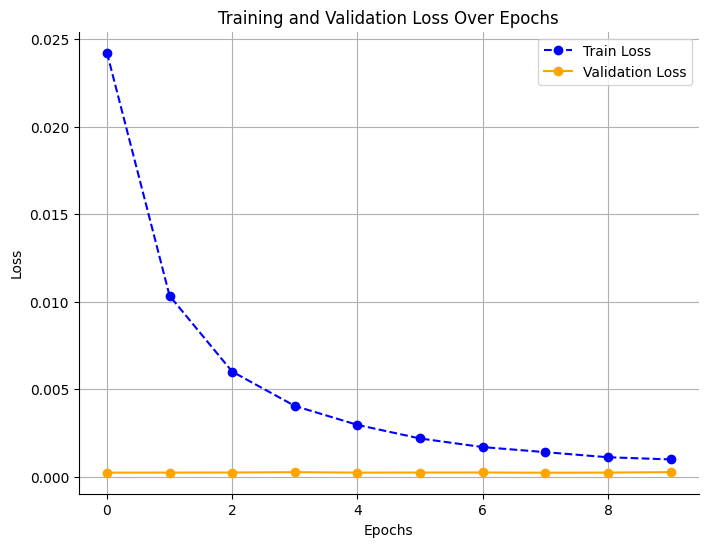

In [ ]:
plot_loss_curve(train_losses = training_loss_2, val_losses = test_loss_CNN)

# Train Network of CNN, VGG16, ResNet

In [ ]:
# Train the model
epochs = 20
dset_sizes = {'trainval': len(train_dataset)}
model_CNN, training_loss, training_acc =  train_model(model_CNN, train_loader, size=dset_sizes['trainval'],epochs=epochs,optimizer=optimizer, patience=10)

Epoch 1/20 - Loss: 0.0170 Acc: 0.6673
Epoch 2/20 - Loss: 0.0046 Acc: 0.9249
Epoch 3/20 - Loss: 0.0023 Acc: 0.9661
Epoch 4/20 - Loss: 0.0014 Acc: 0.9800
Epoch 5/20 - Loss: 0.0009 Acc: 0.9887
Epoch 6/20 - Loss: 0.0007 Acc: 0.9914
Epoch 7/20 - Loss: 0.0005 Acc: 0.9944
Epoch 8/20 - Loss: 0.0004 Acc: 0.9950
Epoch 9/20 - Loss: 0.0003 Acc: 0.9962
Epoch 10/20 - Loss: 0.0003 Acc: 0.9965
Epoch 11/20 - Loss: 0.0003 Acc: 0.9971
Epoch 12/20 - Loss: 0.0002 Acc: 0.9977
Epoch 13/20 - Loss: 0.0002 Acc: 0.9976
Epoch 14/20 - Loss: 0.0002 Acc: 0.9976
Epoch 15/20 - Loss: 0.0002 Acc: 0.9981
Epoch 16/20 - Loss: 0.0002 Acc: 0.9975
Epoch 17/20 - Loss: 0.0001 Acc: 0.9981
Epoch 18/20 - Loss: 0.0001 Acc: 0.9991
Epoch 19/20 - Loss: 0.0001 Acc: 0.9984
Epoch 20/20 - Loss: 0.0001 Acc: 0.9990


In [ ]:
dset_sizes = {'trainval': len(train_dataset)}

model_vgg, training_loss_vgg, training_acc_vgg =  train_model(model_vgg, train_loader, size=dset_sizes['trainval'],epochs=epochs,optimizer=optimizer, patience=4)

Epoch 1/20 - Loss: 0.0345 Acc: 0.1862
Epoch 2/20 - Loss: 0.0345 Acc: 0.1898
Epoch 3/20 - Loss: 0.0346 Acc: 0.1881
Epoch 4/20 - Loss: 0.0346 Acc: 0.1847
Epoch 5/20 - Loss: 0.0346 Acc: 0.1887
Epoch 6/20 - Loss: 0.0346 Acc: 0.1863
Epoch 7/20 - Loss: 0.0345 Acc: 0.1895
Epoch 9/20 - Loss: 0.0346 Acc: 0.1879
Epoch 10/20 - Loss: 0.0346 Acc: 0.1861
Epoch 11/20 - Loss: 0.0346 Acc: 0.1816
Epoch 12/20 - Loss: 0.0345 Acc: 0.1826
Epoch 13/20 - Loss: 0.0345 Acc: 0.1848
Epoch 14/20 - Loss: 0.0346 Acc: 0.1849


KeyboardInterrupt: 

In [ ]:
model_resnet, training_loss_resnet, training_acc_resnet =  train_model(model_resnet, train_loader, size=dset_sizes['trainval'],epochs=epochs,optimizer=optimizer, patience=4)

Epoch 1/20 - Loss: 0.0004 Acc: 0.9926
Epoch 2/20 - Loss: 0.0004 Acc: 0.9931
Epoch 3/20 - Loss: 0.0004 Acc: 0.9919


KeyboardInterrupt: 

# Test the network

In [ ]:
dset_sizes = {'test': len(test_dataset)}
num_classes = len(full_dataset.lookup)  # Number of gesture classes
epochs = 20

predictions_CNN, all_proba_CNN, all_classes_CNN, test_loss_CNN, test_acc_CNN = test_model(model_CNN, test_loader, size=dset_sizes['test'], criterion=criterion, num_epochs = epochs,device=device)

Epoch 1/20 - Loss: 0.0000 Acc: 1.0000
Epoch 2/20 - Loss: 0.0000 Acc: 0.9988


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, epochs + 1), test_loss_CNN, label='Validation Loss', color='orange', marker='o')
plt.plot(range(1, epochs + 1), training_loss, label='Train Loss', color='blue', marker='o', linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')

# Model Loss Comparison

In [ ]:
dset_sizes = {'test': len(test_dataset)}
predictions_resnet, all_proba_resnet, all_classes_resnet, test_loss_resnet, test_acc_resnet = test_model(model_resnet, test_loader, size=dset_sizes['test'], criterion=criterion, num_epochs = epochs,device=device)

In [ ]:
predictions_vgg, all_proba_vgg, all_classes_vgg, test_loss_vgg, test_acc_vgg = test_model(model_vgg, test_loader, size=dset_sizes['test'], criterion=criterion, num_epochs = epochs,device=device)

In [ ]:
plt.figure(figsize=(8, 6))

# Plot for Custom CNN
plt.plot(range(1, len(test_acc_CNN) + 1), test_acc_CNN, label='Custom CNN', color='blue', marker='o')

# Plot for ResNet18
plt.plot(range(1, len(test_acc_resnet) + 1), test_acc_resnet, label='ResNet18', color='orange', marker='x')

# Plot for Vgg16
plt.plot(range(1, len(test_acc_vgg) + 1), test_acc_vgg, label='VGG16', color='Green', marker='x')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.title('Validation Accuracy per Epoch for Custom CNN, ResNet18 and VGG16', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Test Visualization

In [ ]:
from PIL import Image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Confusion Maxtrix


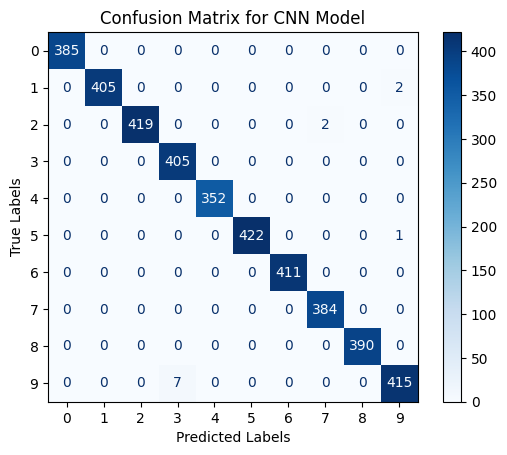

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = num_classes
predictions = predictions_CNN  # Predicted labels
all_classes = all_classes_CNN  # True labels

# Compute the confusion matrix
cm = confusion_matrix(all_classes, predictions, labels=range(num_classes))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for CNN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()